In [1]:
from copy import deepcopy

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from xgboost import XGBClassifier

np.random.seed(42)
torch.manual_seed(42)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


# Project objective:
I want to compare several options to deal with small and missing values dataset.

# Loading dataset
Im using heart disease dataset from: https://www.kaggle.com/datasets/mfarhaannazirkhan/heart-dataset.


This dataset consist 2181 record, and 14 features: age, sex, cp, trestbps, chol, fbs, restecg, thalachh, exang, oldpeak, slope, ca, thal, target. Where target consist information if 1 - person has a hearth disease, or 0 - person is healthy.


In [2]:
raw_dataset = pd.read_csv('raw_merged_heart_dataset.csv')

print(f"Number of samples in dataset: {len(raw_dataset)}.")
print(f"Number of duplicated samples in dataset: {raw_dataset.duplicated().sum()}.")

Number of samples in dataset: 2181.
Number of duplicated samples in dataset: 1287.


Unfortunalety most data is duplicated.

In [3]:
raw_dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2181 entries, 0 to 2180
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2181 non-null   int64  
 1   sex       2181 non-null   int64  
 2   cp        2181 non-null   int64  
 3   trestbps  2181 non-null   object 
 4   chol      2181 non-null   object 
 5   fbs       2181 non-null   object 
 6   restecg   2181 non-null   object 
 7   thalachh  2181 non-null   object 
 8   exang     2181 non-null   object 
 9   oldpeak   2181 non-null   float64
 10  slope     2181 non-null   object 
 11  ca        2181 non-null   object 
 12  thal      2181 non-null   object 
 13  target    2181 non-null   int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 238.7+ KB


Unfortunately most feature despite having numeric data, has string.

In [5]:
for i in raw_dataset.columns:  # loop to change dtype of cols to numeric
    if raw_dataset[i].dtype == 'object':
        raw_dataset[i] = pd.to_numeric(raw_dataset[i], downcast='integer', errors='coerce')

Now I want to drop duplicates to use only unique records.

In [6]:
print(f"Number of samples in dataset with duplicates: {len(raw_dataset)}.")
raw_dataset.drop_duplicates(inplace=True)
print(f"Number of samples in dataset after removing duplicates: {len(raw_dataset)}.")


Number of samples in dataset with duplicates: 2181.
Number of samples in dataset after removing duplicates: 894.


In [7]:
pd.concat([raw_dataset.nunique(), raw_dataset.dtypes, raw_dataset.isna().sum()],
          keys=["Number of unique values", "Dtype od column", "Number of Nans values"], axis=1).reset_index(
    names=["Name of columns"])

,Name of columns,Number of unique values,Dtype od column,Number of Nans values
0,age,47,int64,0
1,sex,2,int64,0
2,cp,5,int64,0
3,trestbps,54,float64,1
4,chol,201,float64,22
5,fbs,2,float64,8
6,restecg,3,float64,1
7,thalachh,103,float64,1
8,exang,2,float64,1
9,oldpeak,41,float64,0


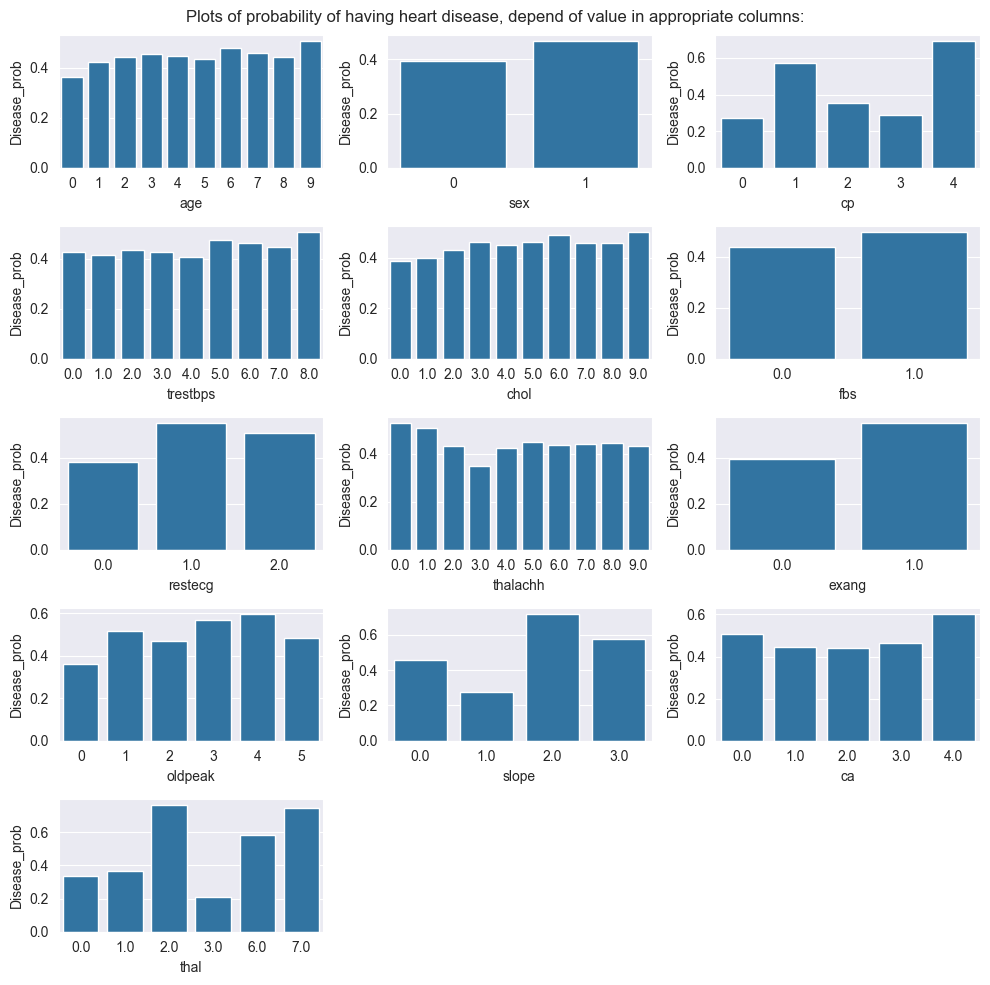

In [9]:
def plot_target_probability(original_df: pd.DataFrame,
                            qcut=10):  # function that plot probability of having disease depends of value of feature
    df = original_df.copy()

    cols = df.drop(columns=["target"]).columns

    number_of_columns = 3
    number_of_rows = np.ceil(len(cols) / number_of_columns).astype(int)

    fig, ax = plt.subplots(nrows=number_of_rows, ncols=number_of_columns, figsize=(10, 10))
    fig.suptitle("Plots of probability of having heart disease, depend of value in appropriate columns:")
    ax = ax.ravel()
    counter = 0  # counter to calculate, how many positions is not used to remove unnecessary empty plots

    for col in cols:
        if df[col].nunique() > 40:  # if column consist too many unique values, better option is to group it
            df[col] = pd.qcut(df[col], qcut, labels=False, duplicates='drop')

        df_agg = df.groupby(col).agg(
            Disease_prob=("target", "mean")
        )

        sns.barplot(x=col, y="Disease_prob", data=df_agg, ax=ax[counter])
        counter += 1

    while counter < number_of_columns * number_of_rows:  # if there are empty plots, they are removing
        ax[counter].remove()
        counter += 1

    plt.tight_layout()
    plt.show()


plot_target_probability(raw_dataset)

In [10]:
print("Matrix of correlation coefficients:")
raw_dataset.corr()

Matrix of correlation coefficients:


,age,sex,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.079294,-0.085903,0.242561,0.152705,0.157099,0.138413,-0.305579,0.138534,0.245134,-0.049422,0.326633,0.024821,0.061686
sex,-0.079294,1.000000,0.052705,-0.014337,-0.116143,0.032172,-0.036036,-0.088777,0.144034,0.101472,0.017718,0.083599,0.201385,0.068153
cp,-0.085903,0.052705,1.000000,0.029835,0.047891,-0.019341,0.083308,-0.135372,0.057105,-0.016416,0.268841,-0.033161,0.546983,0.224668
trestbps,0.242561,-0.014337,0.029835,1.000000,0.117430,0.141215,0.006683,-0.091657,0.109597,0.193527,0.027794,0.087726,0.062468,0.038586
chol,0.152705,-0.116143,0.047891,0.117430,1.000000,0.044757,0.038117,-0.052636,0.104290,0.062181,0.039544,0.117608,0.052473,0.075108
fbs,0.157099,0.032172,-0.019341,0.141215,0.044757,1.000000,0.036103,0.012133,0.041850,0.025035,-0.028598,0.126495,0.000230,0.037819
restecg,0.138413,-0.036036,0.083308,0.006683,0.038117,0.036103,1.000000,0.054468,0.035640,0.105195,0.093382,0.010452,0.150532,0.127815
thalachh,-0.305579,-0.088777,-0.135372,-0.091657,-0.052636,0.012133,0.054468,1.000000,-0.373883,-0.271734,-0.056409,-0.234559,-0.162395,-0.048737
exang,0.138534,0.144034,0.057105,0.109597,0.104290,0.041850,0.035640,-0.373883,1.000000,0.366017,0.079558,0.138680,0.182091,0.147273
oldpeak,0.245134,0.101472,-0.016416,0.193527,0.062181,0.025035,0.105195,-0.271734,0.366017,1.000000,0.000208,0.240747,0.149270,0.133754


[]

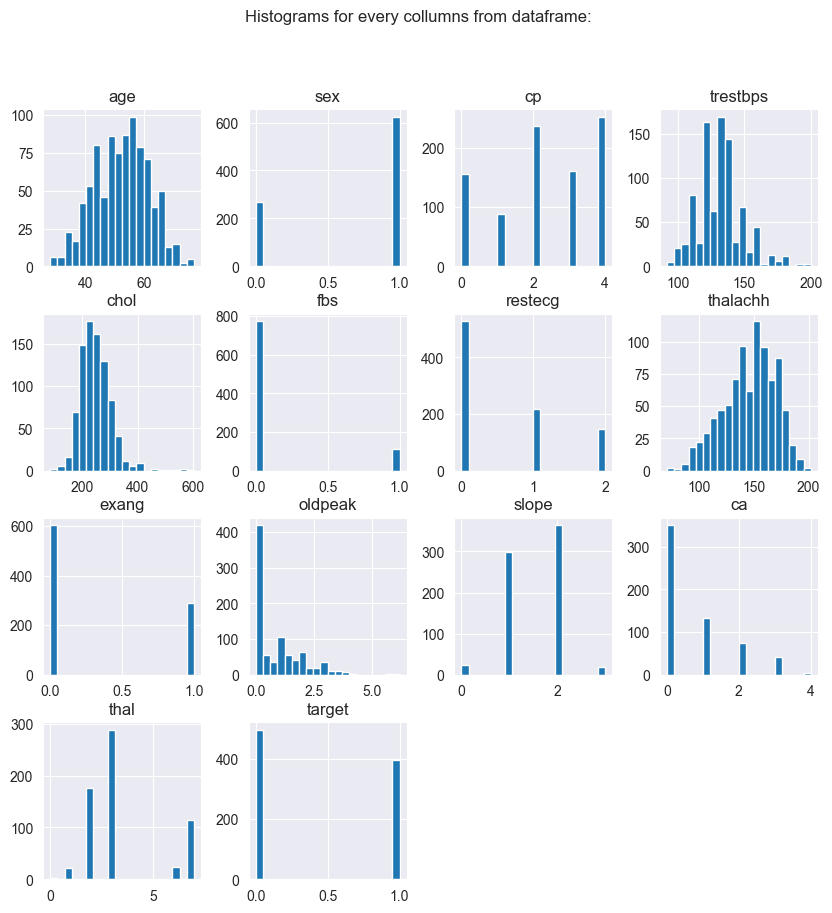

In [11]:
raw_dataset.hist(bins=20, figsize=(10, 10))
plt.suptitle("Histograms for every collumns from dataframe:")
plt.plot()

# Train_test_split

It's time to make train and test datasets, I want to have test set contains only this records which do not have any Nans values.

In [12]:
raw_dataset_records_contains_nans = raw_dataset.loc[raw_dataset.isna().sum(axis=1) > 0]
raw_dataset_record_not_contains_nans = raw_dataset.loc[raw_dataset.isna().sum(axis=1) == 0]

print(f"Number of records having NaNs: {len(raw_dataset_records_contains_nans)}")
print(f"Number of records not having NaNs: {len(raw_dataset_record_not_contains_nans)}")


Number of records having NaNs: 292
Number of records not having NaNs: 602


Making test set:

In [13]:
raw_dataset_record_not_contains_nans, raw_dataset_test = train_test_split(raw_dataset_record_not_contains_nans,
                                                                          stratify=raw_dataset_record_not_contains_nans[
                                                                              "target"],
                                                                          test_size=100, random_state=42)

Merging remaining records to create train set:

In [14]:
raw_dataset_train = pd.concat([raw_dataset_records_contains_nans, raw_dataset_record_not_contains_nans],
                              ignore_index=True)

In [15]:
print(f"Number of records in train set: {len(raw_dataset_train)}")
print(f"Number of records in test set:  {len(raw_dataset_test)}")

Number of records in train set: 794
Number of records in test set:  100


In [16]:
print(f"Number of percent disease samples in train set: {round(raw_dataset_train.target.mean() * 100)}%.")
print(f"Number of percent disease samples in test set:  {round(raw_dataset_test.target.mean() * 100)}%.")
print(f"Number of percent disease samples in full set:  {round(raw_dataset.target.mean() * 100)}%.")

Number of percent disease samples in train set: 44%.
Number of percent disease samples in test set:  49%.
Number of percent disease samples in full set:  44%.


# Neural Network - Useful Functions

Neural Network general sequention model, depending of size of input data (param: input_size), number neurons in layer (param: n_neurons_per_layer) and number of layers (param: n_layer).

In [17]:
class Net(nn.Module):
    def __init__(self, input_size, n_neurons_per_layer, n_layers):
        """
        :param input_size: size of input layer,
        :param n_neurons_per_layer: number of neurons per layer,
        :param n_layers: number of layers in model.
        """
        super(Net, self).__init__()
        layers = []
        layers.append(nn.BatchNorm1d(input_size))

        if n_layers == 1:
            layers.append(nn.Linear(input_size, 1))
        else:
            layers.append(nn.Linear(input_size, n_neurons_per_layer))
            layers.append(nn.ReLU())
            for _ in range(n_layers - 2):
                layers.append(nn.Linear(n_neurons_per_layer, n_neurons_per_layer))
                layers.append(nn.BatchNorm1d(n_neurons_per_layer))
                layers.append(nn.ReLU())
            layers.append(nn.Linear(n_neurons_per_layer, 1))

        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)



Function to training models:

In [18]:
def train(model, train_loader, val_loader, epochs=100, lr=0.001, scheduler_gamma=0.5):
    """
    :param model: model to be trained,
    :param train_loader: dataloader with training data,
    :param val_loader: dataloader with validation data,
    :param epochs: number of epochs,
    :param lr: learning rate to optimize model,
    :param scheduler_gamma: gamma for learning rate scheduler, if 0 then without schedulering,
    :return: tuple, consist losses and accuracies for training and validation data and dict with the best weights.
    """

    train_losses = []
    train_accuracies = []

    eval_losses = []
    eval_accuracies = []

    best_eval_acc = 0
    best_state = None

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=scheduler_gamma)
    criterion = nn.BCELoss()

    for epoch in range(epochs):

        print(epoch + 1, '/', epochs, sep='', end=' ')

        model.train()
        train_loss = 0
        train_acc = 0
        for X, y in train_loader:
            # print("xD")
            optimizer.zero_grad()
            y_pred = model(X)
            # print(y_pred.shape, y.shape)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            acc = accuracy_score((y_pred > 0.5).cpu().detach(), y.cpu())
            train_acc += acc

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        train_acc /= len(train_loader)
        train_accuracies.append(train_acc)

        scheduler.step()
        print("Train loss:", train_loss, "| Train acc:", train_acc, end=' ')

        model.eval()
        eval_loss = 0
        eval_acc = 0
        for X, y in val_loader:
            y_pred = model(X)

            loss = criterion(y_pred, y)
            eval_loss += loss.item()

            acc = accuracy_score((y_pred > 0.5).cpu().detach(), y.cpu())
            eval_acc += acc

        eval_loss /= len(val_loader)
        eval_losses.append(eval_loss)

        eval_acc /= len(val_loader)
        eval_accuracies.append(eval_acc)

        print("Val loss: ", eval_loss, "| Val acc:", eval_acc)

        if eval_acc >= best_eval_acc:
            best_eval_acc = eval_acc
            best_state = deepcopy(model.state_dict())

    print("Best_eval acc:", best_eval_acc)
    return [train_losses, train_accuracies, eval_losses, eval_accuracies], best_state


Function to automaticaly creating dataloaders

In [19]:
def make_dataloader(dataset, batch_size=64):
    """
    :param dataset: dataset to be loaded,
    :param batch_size: size of batch,
    :return: tuple consist training dataloader and validation dataloader.
    """
    train_set, eval_set = train_test_split(dataset, test_size=0.1,
                                           stratify=dataset["target"],
                                           random_state=42)

    train_dataset = TensorDataset(
        torch.Tensor(train_set.drop(columns=["target"]).to_numpy()).to(device),
        torch.Tensor(train_set["target"].to_numpy()).unsqueeze(1).to(device)
    )

    eval_dataset = TensorDataset(
        torch.Tensor(eval_set.drop(columns=["target"]).to_numpy()).to(device),
        torch.Tensor(eval_set["target"].to_numpy()).unsqueeze(1).to(device)
    )

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, eval_dataloader


# Options to deal with Nans values:

1. Cleaning dataset - I'm going to remove all Nans values. In this way I'll have only pure data.
2. Imputing dataset - I'm going to fill Nans values using SimpleImputer with median collum value.
3. Supplement dataset - I'm going to fill Nans values using classificatior such as XGBoost or Random Forest.

# Cleaning dataset

In this part, I want to delete Nans values. Depending of correlation coefficient I delete entire collumns, or only a few records.

In [21]:
raw_dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       794 non-null    int64  
 1   sex       794 non-null    int64  
 2   cp        794 non-null    int64  
 3   trestbps  793 non-null    float64
 4   chol      772 non-null    float64
 5   fbs       786 non-null    float64
 6   restecg   793 non-null    float64
 7   thalachh  793 non-null    float64
 8   exang     793 non-null    float64
 9   oldpeak   794 non-null    float64
 10  slope     605 non-null    float64
 11  ca        504 non-null    float64
 12  thal      529 non-null    float64
 13  target    794 non-null    int64  
dtypes: float64(10), int64(4)
memory usage: 87.0 KB


It looks like columns: slope, ca, thal consist really many Nans values, but collumn slope has relatively great corelation coefficient with target column, so I decided to remove all ca and thal columns, and leave slope column.

In [22]:
clean_dataset = raw_dataset_train.drop(columns=["thal", "ca"])
clean_dataset_test = raw_dataset_test.drop(columns=["thal", "ca"])
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       794 non-null    int64  
 1   sex       794 non-null    int64  
 2   cp        794 non-null    int64  
 3   trestbps  793 non-null    float64
 4   chol      772 non-null    float64
 5   fbs       786 non-null    float64
 6   restecg   793 non-null    float64
 7   thalachh  793 non-null    float64
 8   exang     793 non-null    float64
 9   oldpeak   794 non-null    float64
 10  slope     605 non-null    float64
 11  target    794 non-null    int64  
dtypes: float64(8), int64(4)
memory usage: 74.6 KB


In [23]:
clean_dataset.dropna(inplace=True)
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 596 entries, 17 to 793
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       596 non-null    int64  
 1   sex       596 non-null    int64  
 2   cp        596 non-null    int64  
 3   trestbps  596 non-null    float64
 4   chol      596 non-null    float64
 5   fbs       596 non-null    float64
 6   restecg   596 non-null    float64
 7   thalachh  596 non-null    float64
 8   exang     596 non-null    float64
 9   oldpeak   596 non-null    float64
 10  slope     596 non-null    float64
 11  target    596 non-null    int64  
dtypes: float64(8), int64(4)
memory usage: 60.5 KB


Only collumns with dtype float could consist Nans, so even if dataset consist integral features, they had float dtype, so i decided to change them to integral dtype.

In [24]:
for col in clean_dataset.columns:
    if (clean_dataset[col] % 1 == 0).all():
        clean_dataset[col] = clean_dataset[col].astype(int)
        clean_dataset_test[col] = clean_dataset_test[col].astype(int)

In [25]:
pd.concat([clean_dataset.nunique(), clean_dataset.dtypes, clean_dataset.isna().sum()],
          keys=["Number of unique values", "Dtype od column", "Number of Nans values"], axis=1).reset_index(
    names=["Name of columns"])



,Name of columns,Number of unique values,Dtype od column,Number of Nans values
0,age,44,int64,0
1,sex,2,int64,0
2,cp,5,int64,0
3,trestbps,51,int64,0
4,chol,172,int64,0
5,fbs,2,int64,0
6,restecg,3,int64,0
7,thalachh,100,int64,0
8,exang,2,int64,0
9,oldpeak,41,float64,0


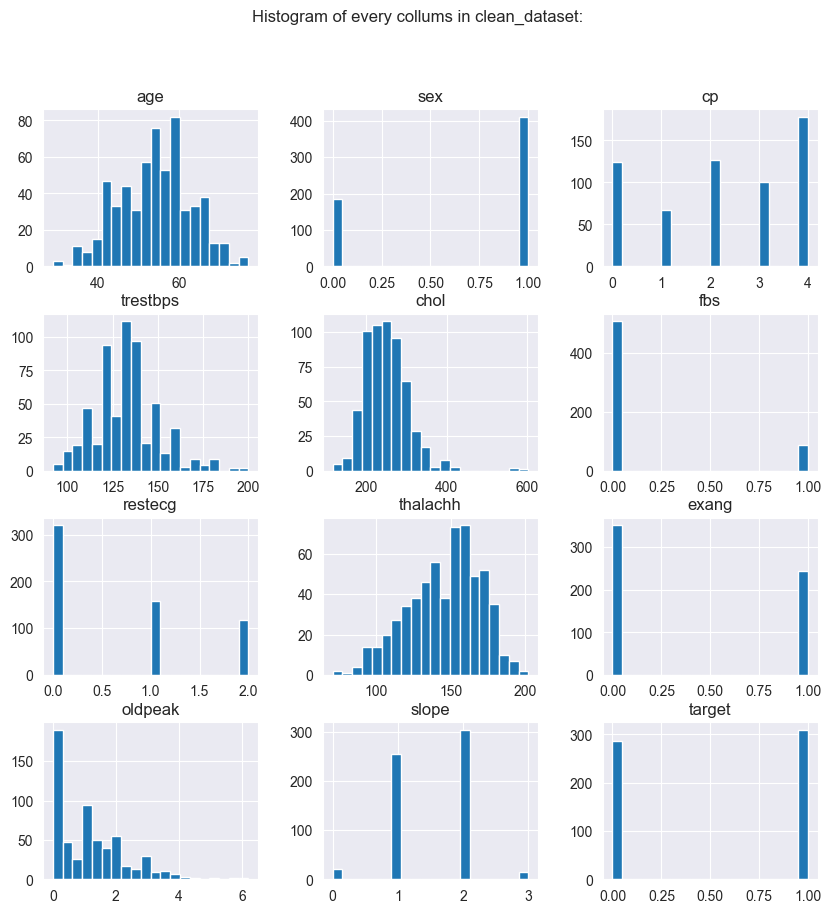

In [26]:
clean_dataset.hist(bins=20, figsize=(10, 10))
plt.suptitle("Histogram of every collums in clean_dataset:")
plt.show()

I see that thalachh and oldpeak columns have longtail distributions, so I use boxcox to change them to normal distribution.

In [27]:
lambdas = {}  # for future applications I should remember boxcox lambdas

for col in ["thalachh", "oldpeak", ]:
    clean_dataset[col], boxcox_lambda = sp.stats.boxcox(clean_dataset[col] + 1e-5, alpha=None, lmbda=None)
    lambdas[col] = boxcox_lambda
    clean_dataset_test[col] = sp.stats.boxcox(clean_dataset_test[col] + 1e-5, alpha=None, lmbda=lambdas[col])


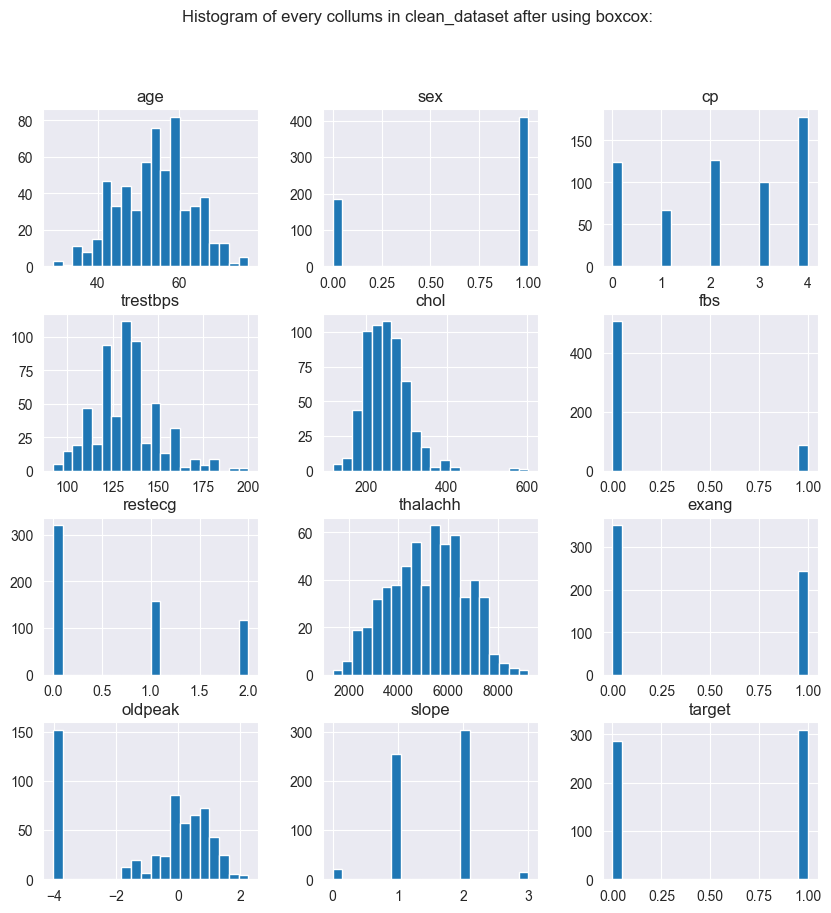

In [28]:
clean_dataset.hist(bins=20, figsize=(10, 10))
plt.suptitle("Histogram of every collums in clean_dataset after using boxcox:")
plt.show()

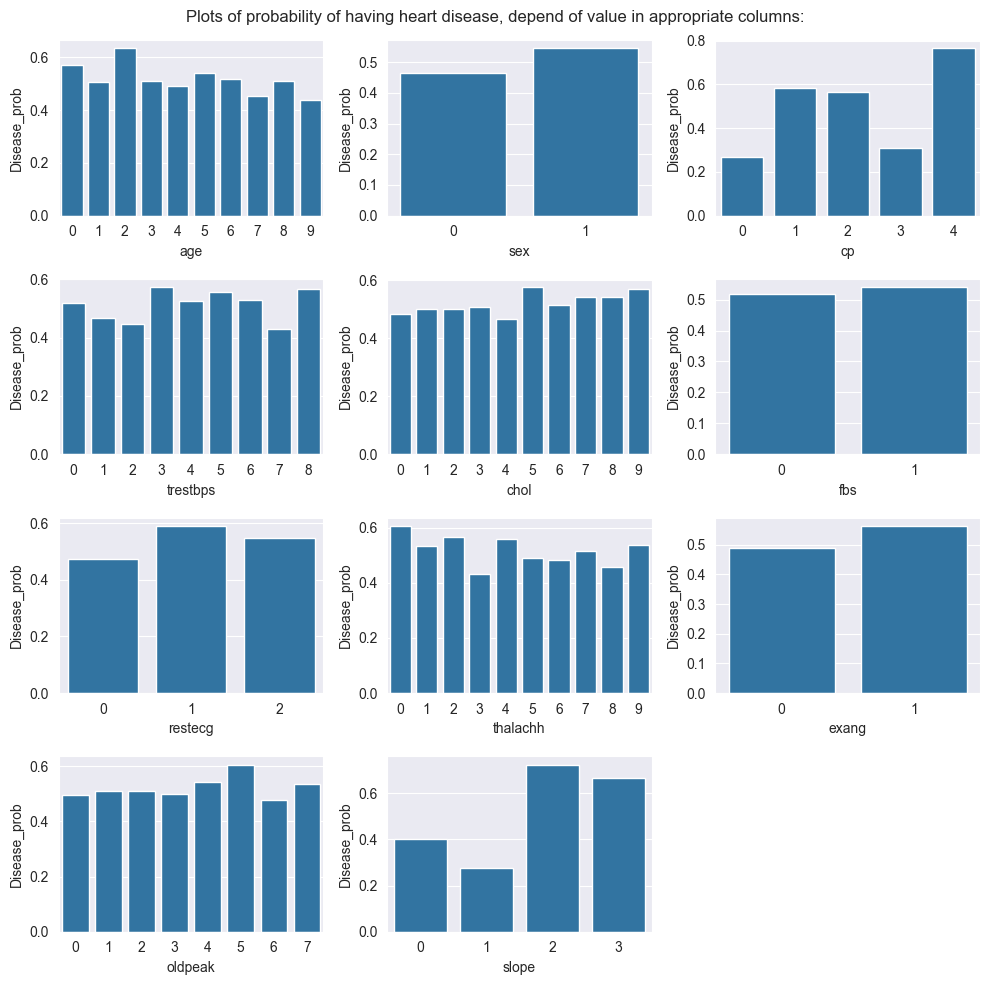

In [29]:
plot_target_probability(clean_dataset)

In [30]:
print("Correlations features matrix:")
clean_dataset.corr()

Correlations features matrix:


,age,sex,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,target
age,1.000000,-0.120530,-0.061673,0.248877,0.178477,0.132765,0.079214,-0.325664,0.027662,0.162932,-0.074576,-0.074138
sex,-0.120530,1.000000,0.021936,-0.010523,-0.160067,0.061679,-0.000054,-0.085997,0.155141,0.112436,-0.001337,0.074222
cp,-0.061673,0.021936,1.000000,0.032431,0.067408,0.007194,0.122913,-0.130355,0.096866,0.099736,0.304584,0.277825
trestbps,0.248877,-0.010523,0.032431,1.000000,0.156676,0.146991,-0.007522,-0.097342,0.117152,0.159742,0.023428,0.039858
chol,0.178477,-0.160067,0.067408,0.156676,1.000000,0.023473,0.024203,-0.066804,0.113359,0.073275,0.027897,0.055742
fbs,0.132765,0.061679,0.007194,0.146991,0.023473,1.000000,-0.002223,0.041951,-0.017031,-0.012334,-0.023399,0.016630
restecg,0.079214,-0.000054,0.122913,-0.007522,0.024203,-0.002223,1.000000,0.022694,-0.002396,-0.059268,0.089202,0.075183
thalachh,-0.325664,-0.085997,-0.130355,-0.097342,-0.066804,0.041951,0.022694,1.000000,-0.430787,-0.429316,-0.068463,-0.051308
exang,0.027662,0.155141,0.096866,0.117152,0.113359,-0.017031,-0.002396,-0.430787,1.000000,0.284965,0.109886,0.072128
oldpeak,0.162932,0.112436,0.099736,0.159742,0.073275,-0.012334,-0.059268,-0.429316,0.284965,1.000000,0.019181,0.029594


### XGBoost

First I use XGBoost model:

In [31]:
clean_xgb_model = XGBClassifier(learning_rate=0.01,
                                max_depth=3,
                                n_estimators=500,
                                subsample=0.8,
                                colsample_bytree=0.8,
                                gamma=1,
                                reg_alpha=0.1,
                                reg_lambda=0.1,
                                # early_stopping_rounds = 50,
                                eval_metric='error',
                                seed=42)

score = cross_val_score(clean_xgb_model,
                        clean_dataset.drop(columns=["target"]),
                        clean_dataset["target"],
                        cv=5).mean()
print(f"XGBoost cross validation score: {round(score, 2)}")

XGBoost cross validation score: 0.71


In [32]:
clean_xgb_model.fit(clean_dataset.drop(columns=["target"]),
                    clean_dataset["target"],
                    verbose=True)

print("Results for XGBoost:")
y_train_pred = clean_xgb_model.predict(clean_dataset.drop(columns=["target"]))
print(f"Train_acc: {round(accuracy_score(clean_dataset.target, y_train_pred), 2)}")
print(f"Train_f1:  {round(f1_score(clean_dataset.target, y_train_pred), 2)}")

y_test_pred = clean_xgb_model.predict(clean_dataset_test.drop(columns=["target"]))
print(f"Test_acc:  {round(accuracy_score(clean_dataset_test.target, y_test_pred), 2)}", )
print(f"Test_f1:   {round(f1_score(clean_dataset_test.target, y_test_pred), 2)}")


Results for XGBoost:
Train_acc: 0.83
Train_f1:  0.84
Test_acc:  0.78
Test_f1:   0.78


In [33]:
print("Confusion matrix for test data:")
print(confusion_matrix(clean_dataset_test["target"], y_test_pred))

Confusion matrix for test data:
[[40 11]
 [11 38]]


### Neural Network

Now it's time to check Neural Network

In [34]:
clean_train_dataloader, clean_eval_dataloader = make_dataloader(
    clean_dataset)  # making dataloaders to training Neural Network

In [35]:
clean_net_model = Net(input_size=len(clean_dataset.columns) - 1,
                      n_neurons_per_layer=10,
                      n_layers=4,
                      ).to(device)

clean_losses, clean_state_dict = train(clean_net_model,
                                       clean_train_dataloader,
                                       clean_eval_dataloader,
                                       epochs=300, lr=0.01, scheduler_gamma=1
                                       )


1/300 Train loss: 0.6793389783965217 | Train acc: 0.5671296296296297 Val loss:  0.6792097687721252 | Val acc: 0.5166666666666667
2/300 Train loss: 0.6159313850932651 | Train acc: 0.6822916666666666 Val loss:  0.6616155505180359 | Val acc: 0.5
3/300 Train loss: 0.5715807146496243 | Train acc: 0.7158564814814814 Val loss:  0.5579758882522583 | Val acc: 0.6833333333333333
4/300 Train loss: 0.5257159471511841 | Train acc: 0.7621527777777778 Val loss:  0.538694441318512 | Val acc: 0.7666666666666667
5/300 Train loss: 0.520414325926039 | Train acc: 0.7505787037037037 Val loss:  0.5743845701217651 | Val acc: 0.7166666666666667
6/300 Train loss: 0.5001348952452341 | Train acc: 0.7569444444444444 Val loss:  0.597042977809906 | Val acc: 0.7166666666666667
7/300 Train loss: 0.5216185284985436 | Train acc: 0.7337962962962963 Val loss:  0.6128841638565063 | Val acc: 0.6833333333333333
8/300 Train loss: 0.5042539570066664 | Train acc: 0.7366898148148148 Val loss:  0.5773245692253113 | Val acc: 0.733

In [36]:
clean_net_model.load_state_dict(clean_state_dict)
clean_net_model.eval()
clean_net_model.to("cpu")

print("Results for Neural Network:")
y_train_pred = clean_net_model(torch.Tensor(clean_dataset.drop(columns=["target"]).to_numpy())).detach() > 0.5
print(f"Train_acc: {round(accuracy_score(clean_dataset.target, y_train_pred), 2)}")
print(f"Train_f1:  {round(f1_score(clean_dataset.target, y_train_pred), 2)}")

y_test_pred = clean_net_model(torch.Tensor(clean_dataset_test.drop(columns=["target"]).to_numpy())).detach() > 0.5
print(f"Test_acc:  {round(accuracy_score(clean_dataset_test.target, y_test_pred), 2)}")
print(f"Test_f1:   {round(f1_score(clean_dataset_test.target, y_test_pred), 2)}")

Results for Neural Network:
Train_acc: 0.89
Train_f1:  0.89
Test_acc:  0.68
Test_f1:   0.7


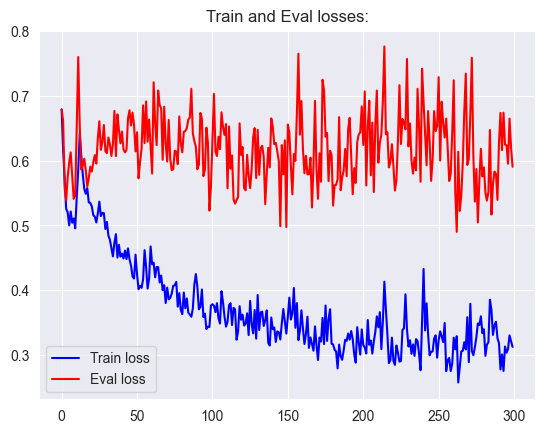

In [37]:
plt.plot(clean_losses[0], "b", label="Train loss")
plt.plot(clean_losses[2], "r", label="Eval loss")
plt.legend()
plt.title("Train and Eval losses:")
plt.show()

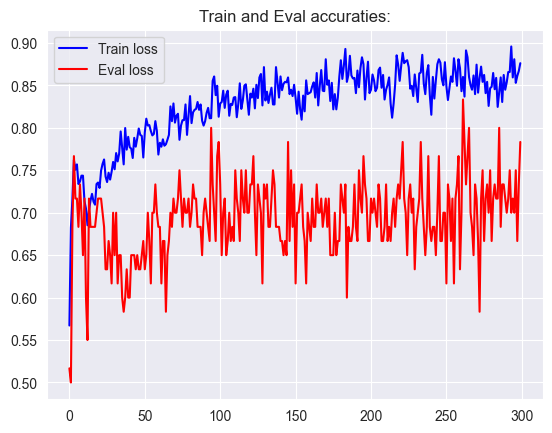

In [38]:
plt.plot(clean_losses[1], "b", label="Train loss")
plt.plot(clean_losses[3], "r", label="Eval loss")
plt.legend()
plt.title("Train and Eval accuraties:")
plt.show()

In [39]:
print("Confusion matrix for test data:")
print(confusion_matrix(clean_dataset_test["target"], y_test_pred))

Confusion matrix for test data:
[[31 20]
 [12 37]]


# Imputing Dataset

In this part I check if better results could gain by filling Nans with median value.

In [40]:
imputer = SimpleImputer(strategy="median", fill_value=0)
imputed_dataset = imputer.fit_transform(raw_dataset_train)
imputed_dataset = pd.DataFrame(imputed_dataset,
                               columns=raw_dataset_train.columns)  # SingleImputer.transform() returns numpy.ndarray, so I should return to dataframe to better data analysis
imputed_dataset_test = raw_dataset_test.copy()  # test set consist no Nans, so I only copy it


In [41]:
imputed_dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,target
0,28.0,1.0,2.0,130.0,132.0,0.0,2.0,185.0,0.0,0.0,2.0,0.0,3.0,0.0
1,29.0,1.0,2.0,120.0,243.0,0.0,0.0,160.0,0.0,0.0,2.0,0.0,3.0,0.0
2,29.0,1.0,2.0,140.0,244.0,0.0,0.0,170.0,0.0,0.0,2.0,0.0,3.0,0.0
3,30.0,0.0,1.0,170.0,237.0,0.0,1.0,170.0,0.0,0.0,2.0,0.0,6.0,0.0
4,31.0,0.0,2.0,100.0,219.0,0.0,1.0,150.0,0.0,0.0,2.0,0.0,3.0,0.0


Only collumns with dtype float could consist Nans, so even if dataset consist integral features, they had float dtype, so i decided to change them to integral dtype.

In [42]:
for col in imputed_dataset.columns:
    if (imputed_dataset[col] % 1 == 0).all():  # if x % 1 == 0, then x is integer
        imputed_dataset[col] = imputed_dataset[col].astype(int)
        imputed_dataset_test[col] = imputed_dataset_test[col].astype(int)

In [43]:
imputed_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       794 non-null    int64  
 1   sex       794 non-null    int64  
 2   cp        794 non-null    int64  
 3   trestbps  794 non-null    int64  
 4   chol      794 non-null    int64  
 5   fbs       794 non-null    int64  
 6   restecg   794 non-null    int64  
 7   thalachh  794 non-null    int64  
 8   exang     794 non-null    int64  
 9   oldpeak   794 non-null    float64
 10  slope     794 non-null    int64  
 11  ca        794 non-null    int64  
 12  thal      794 non-null    int64  
 13  target    794 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 87.0 KB


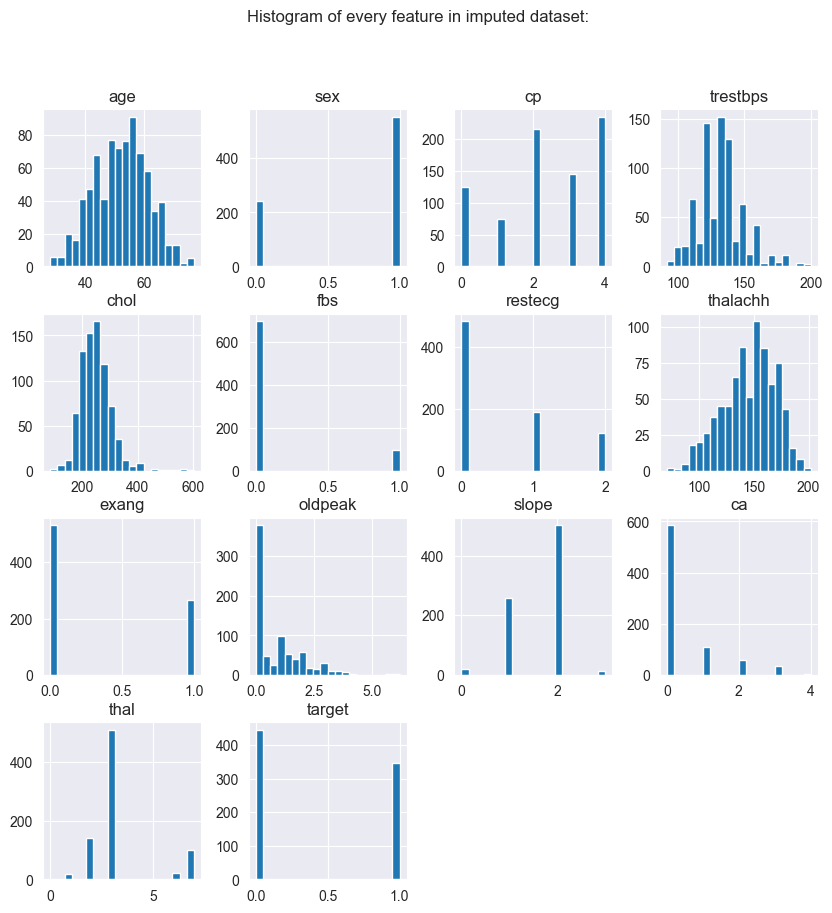

In [44]:
imputed_dataset.hist(bins=20, figsize=(10, 10))
plt.suptitle("Histogram of every feature in imputed dataset:")
plt.show()

Thalach and oldpeak columns have long tail distributions, so I use boxcox to change them to normal distribution.

In [45]:
lambdas = {}  # I should save boxcox lambdas to future uses

for col in ["thalachh", "oldpeak", ]:  # "age", "trestbps", "chol",
    imputed_dataset[col], boxcox_lambda = sp.stats.boxcox(imputed_dataset[col] + 1e-5, alpha=None, lmbda=None)
    lambdas[col] = boxcox_lambda
    imputed_dataset_test[col] = sp.stats.boxcox(imputed_dataset_test[col] + 1e-5, alpha=None, lmbda=lambdas[col])


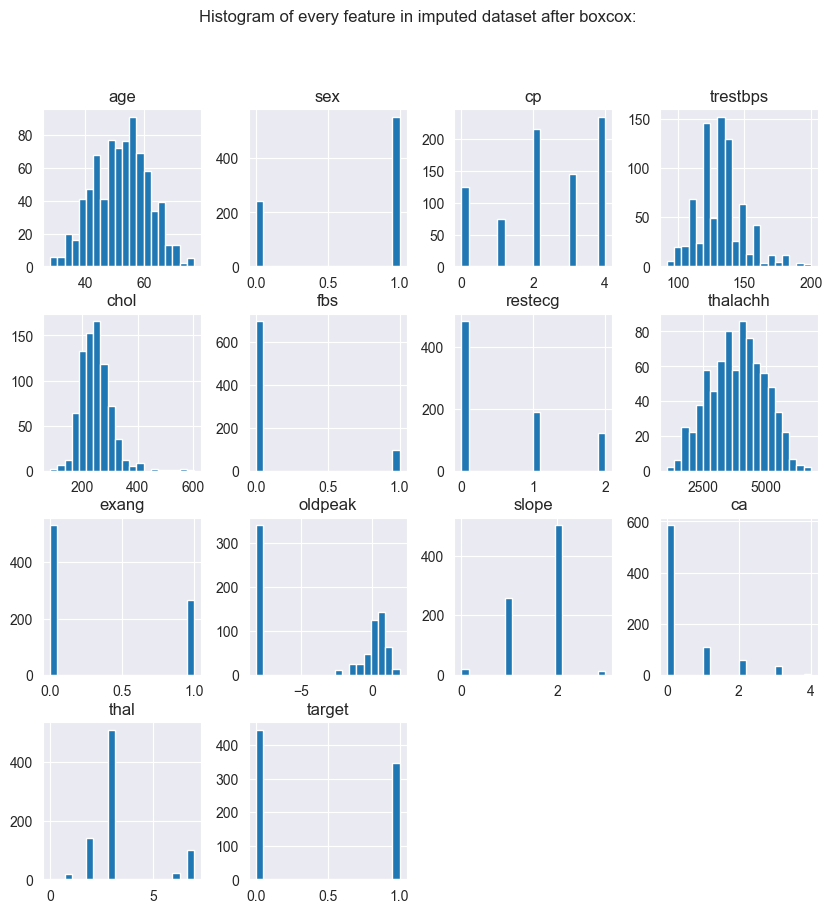

In [46]:
imputed_dataset.hist(bins=20, figsize=(10, 10))
plt.suptitle("Histogram of every feature in imputed dataset after boxcox:")
plt.show()

In [47]:
print("Matrix of correlation of features:")
imputed_dataset.corr()

Matrix of correlation of features:


,age,sex,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.088150,-0.086861,0.237865,0.144113,0.163678,0.150259,-0.319800,0.143841,0.323457,-0.181044,0.371454,0.059336,0.064739
sex,-0.088150,1.000000,0.064000,0.012376,-0.109274,0.047848,-0.036561,-0.091475,0.140309,0.054029,0.010218,0.041910,0.150992,0.097314
cp,-0.086861,0.064000,1.000000,0.014910,0.059540,-0.011077,0.053172,-0.151548,0.068744,-0.012049,0.323391,-0.147814,0.425886,0.232680
trestbps,0.237865,0.012376,0.014910,1.000000,0.114105,0.138125,0.002906,-0.092300,0.119901,0.134633,-0.001266,0.067335,0.046628,0.039332
chol,0.144113,-0.109274,0.059540,0.114105,1.000000,0.019015,0.033997,-0.066599,0.108214,0.090247,0.003190,0.070478,0.041235,0.094456
fbs,0.163678,0.047848,-0.011077,0.138125,0.019015,1.000000,0.037485,0.017107,0.027761,0.065287,-0.061633,0.148993,0.002630,0.062105
restecg,0.150259,-0.036561,0.053172,0.002906,0.033997,0.037485,1.000000,0.034810,0.069334,0.106266,-0.020821,0.164142,0.156900,0.123553
thalachh,-0.319800,-0.091475,-0.151548,-0.092300,-0.066599,0.017107,0.034810,1.000000,-0.369280,-0.286146,-0.065299,-0.083306,-0.110607,-0.063674
exang,0.143841,0.140309,0.068744,0.119901,0.108214,0.027761,0.069334,-0.369280,1.000000,0.387460,-0.009034,0.113981,0.152519,0.195541
oldpeak,0.323457,0.054029,-0.012049,0.134633,0.090247,0.065287,0.106266,-0.286146,0.387460,1.000000,-0.206511,0.220054,0.149792,0.211434


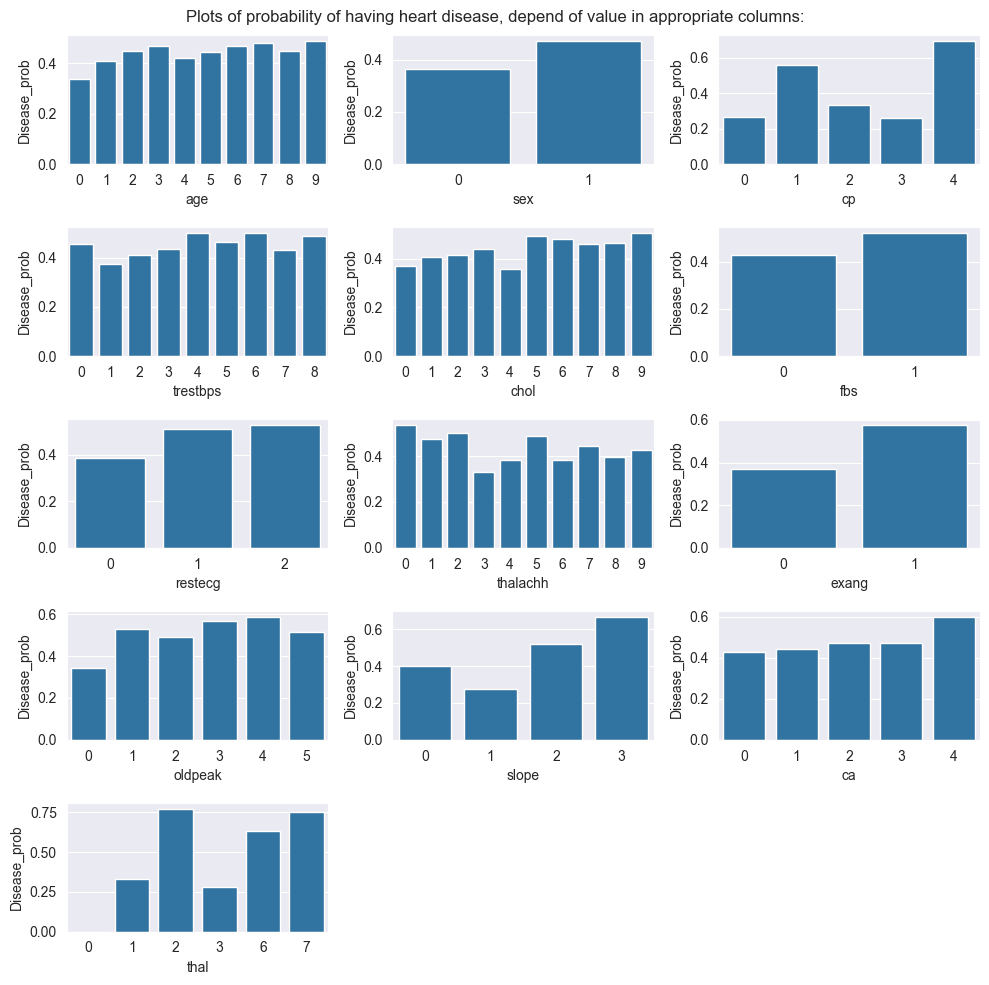

In [48]:
plot_target_probability(imputed_dataset)

### XGBoost

Firstly I train XGBoost:

In [49]:
imputed_xgb_model = XGBClassifier(learning_rate=0.001,
                                  max_depth=3,
                                  n_estimators=1000,
                                  subsample=0.8,
                                  colsample_bytree=0.9,
                                  # gamma=1,
                                  reg_alpha=0.5,
                                  reg_lambda=0.5,
                                  # early_stopping_rounds = 50,
                                  eval_metric='error',
                                  seed=42)

score = cross_val_score(imputed_xgb_model,
                        imputed_dataset.drop(columns=["target"]),
                        imputed_dataset["target"],
                        cv=5).mean()
print(f"XGBoost model cross validation score: {round(score, 2)}")

XGBoost model cross validation score: 0.8


In [50]:
imputed_xgb_model.fit(imputed_dataset.drop(columns=["target"]),
                      imputed_dataset["target"],
                      verbose=True)

print("Results for XGBoost:")

y_train_pred = imputed_xgb_model.predict(imputed_dataset.drop(columns=["target"]))
print(f"Train_acc: {round(accuracy_score(imputed_dataset.target, y_train_pred), 2)}")
print(f"Train_f1:  {round(f1_score(imputed_dataset.target, y_train_pred), 2)}")

y_test_pred = imputed_xgb_model.predict(imputed_dataset_test.drop(columns=["target"]))
print(f"Test_acc:  {round(accuracy_score(imputed_dataset_test.target, y_test_pred), 2)}")
print(f"Test_f1:   {round(f1_score(imputed_dataset_test.target, y_test_pred), 2)}")

Results for XGBoost:
Train_acc: 0.82
Train_f1:  0.78
Test_acc:  0.83
Test_f1:   0.81


In [51]:
print("Confusion matrix for test data:")
print(confusion_matrix(imputed_dataset_test["target"], y_test_pred))

Confusion matrix for test data:
[[46  5]
 [12 37]]


### Neural Network

In [52]:
imputed_train_dataloader, imputed_eval_dataloader = make_dataloader(imputed_dataset)

In [53]:

imputed_net_model = Net(input_size=len(imputed_dataset.columns) - 1,
                        n_neurons_per_layer=20,
                        n_layers=3,
                        ).to(device)

my_imputed_losses, my_imputed_state_dict = train(imputed_net_model,
                                                 imputed_train_dataloader,
                                                 imputed_eval_dataloader,
                                                 epochs=300, lr=0.01, scheduler_gamma=0.5
                                                 )

1/300 Train loss: 0.6367951581875483 | Train acc: 0.6315104166666666 Val loss:  0.638416200876236 | Val acc: 0.7109375
2/300 Train loss: 0.5251007527112961 | Train acc: 0.7502604166666668 Val loss:  0.5153965651988983 | Val acc: 0.8203125
3/300 Train loss: 0.4879934638738632 | Train acc: 0.7731770833333332 Val loss:  0.45023640990257263 | Val acc: 0.84375
4/300 Train loss: 0.47648804634809494 | Train acc: 0.7739583333333333 Val loss:  0.4519408941268921 | Val acc: 0.7578125
5/300 Train loss: 0.45758887628714245 | Train acc: 0.8122395833333332 Val loss:  0.42006245255470276 | Val acc: 0.765625
6/300 Train loss: 0.42919105539719266 | Train acc: 0.8244791666666668 Val loss:  0.4337405860424042 | Val acc: 0.7734375
7/300 Train loss: 0.420487883190314 | Train acc: 0.8315104166666667 Val loss:  0.40345416963100433 | Val acc: 0.84375
8/300 Train loss: 0.47049783418575924 | Train acc: 0.78359375 Val loss:  0.4888870418071747 | Val acc: 0.78125
9/300 Train loss: 0.5959878365198771 | Train acc: 

In [55]:
# my_imputed_state_dict_ = torch.load("best_imputed_model_state_dict.pth")
# my_imputed_model.load_state_dict(my_imputed_state_dict_)


imputed_net_model.eval()
imputed_net_model.to("cpu")

print("Results for Neural Network:")

y_train_pred = imputed_net_model(torch.Tensor(imputed_dataset.drop(columns=["target"]).to_numpy())).detach() > 0.5
print(f"Train_acc: {round(accuracy_score(imputed_dataset.target, y_train_pred), 2)}")
print(f"Train_f1:  {round(f1_score(imputed_dataset.target, y_train_pred), 2)}")

y_test_pred = imputed_net_model(torch.Tensor(imputed_dataset_test.drop(columns=["target"]).to_numpy())).detach() > 0.5
print(f"Test_acc:  {round(accuracy_score(imputed_dataset_test.target, y_test_pred), 2)}")
print(f"Test_f1:   {round(f1_score(imputed_dataset_test.target, y_test_pred), 2)}")


Results for Neural Network:
Train_acc: 0.9
Train_f1:  0.88
Test_acc:  0.81
Test_f1:   0.8


In [56]:
print("Confusion matrix for test data:")
print(confusion_matrix(imputed_dataset_test["target"], y_test_pred))

Confusion matrix for test data:
[[43  8]
 [11 38]]


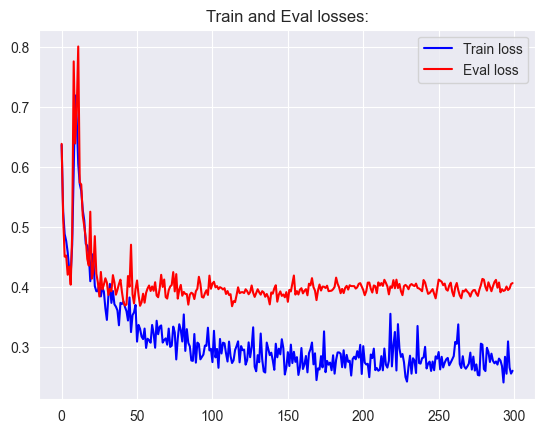

In [57]:
plt.plot(my_imputed_losses[0], "b", label="Train loss")
plt.plot(my_imputed_losses[2], "r", label="Eval loss")
plt.legend()
plt.title("Train and Eval losses:")
plt.show()

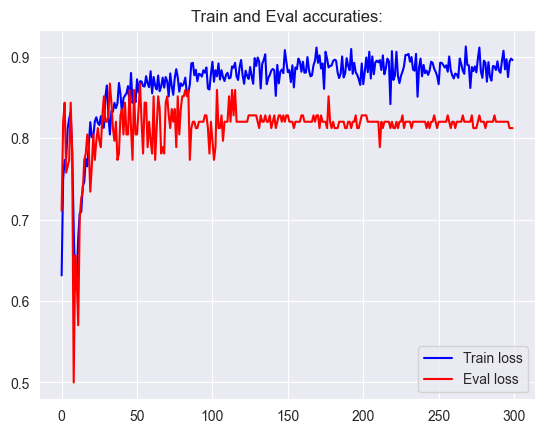

In [58]:
plt.plot(my_imputed_losses[1], "b", label="Train loss")
plt.plot(my_imputed_losses[3], "r", label="Eval loss")
plt.legend()
plt.title("Train and Eval accuraties:")
plt.show()

# Suplement data using XGBOOST

I'll try to fill values in slope column using some classificators, because it has relatively great correlation coefficient with target column.

In [59]:
supplement_dataset = raw_dataset_train.drop(
    columns=["thal", "ca"])  # I decided to remove thal and ca columns beacuse they cosist too many Nans
supplement_dataset_test = raw_dataset_test.drop(columns=["thal", "ca"])
supplement_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       794 non-null    int64  
 1   sex       794 non-null    int64  
 2   cp        794 non-null    int64  
 3   trestbps  793 non-null    float64
 4   chol      772 non-null    float64
 5   fbs       786 non-null    float64
 6   restecg   793 non-null    float64
 7   thalachh  793 non-null    float64
 8   exang     793 non-null    float64
 9   oldpeak   794 non-null    float64
 10  slope     605 non-null    float64
 11  target    794 non-null    int64  
dtypes: float64(8), int64(4)
memory usage: 74.6 KB


In [60]:
supplement_dataset = supplement_dataset.dropna(subset=supplement_dataset.columns[:10])

for col in supplement_dataset.columns:  # changing dtype float to int, where column consist only integer values
    if (supplement_dataset[col] % 1 == 0).all():
        supplement_dataset[col] = supplement_dataset[col].astype(int)
        supplement_dataset_test[col] = supplement_dataset_test[col].astype(int)

supplement_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 762 entries, 0 to 793
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       762 non-null    int64  
 1   sex       762 non-null    int64  
 2   cp        762 non-null    int64  
 3   trestbps  762 non-null    int64  
 4   chol      762 non-null    int64  
 5   fbs       762 non-null    int64  
 6   restecg   762 non-null    int64  
 7   thalachh  762 non-null    int64  
 8   exang     762 non-null    int64  
 9   oldpeak   762 non-null    float64
 10  slope     596 non-null    float64
 11  target    762 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 77.4 KB


In [61]:
lambdas = {}

for col in ["thalachh", "oldpeak", ]:  # this columns distributions should be improved to normal
    supplement_dataset[col], boxcox_lambda = sp.stats.boxcox(supplement_dataset[col] + 1e-5, alpha=None, lmbda=None)
    lambdas[col] = boxcox_lambda
    supplement_dataset_test[col] = sp.stats.boxcox(supplement_dataset_test[col] + 1e-5, alpha=None, lmbda=lambdas[col])


Firstly I split supplement dataset to dataset contains only Nan values in columns Slope, and only non Nan values

In [62]:
supplement_dataset_slope_nan = supplement_dataset[supplement_dataset["slope"].isna()]
supplement_dataset_slope_non_nan = supplement_dataset[supplement_dataset["slope"].isna() ^ True]


Now using datasets with non Nan values in column slope, I create training and test sets to train classifier to predict slope values

In [63]:
X_slope_train, X_slope_test, y_slope_train, y_slope_test = train_test_split(
    supplement_dataset_slope_non_nan.drop(columns=["target", "slope"]), supplement_dataset_slope_non_nan["slope"],
    stratify=supplement_dataset_slope_non_nan["slope"],
    test_size=100, random_state=42)

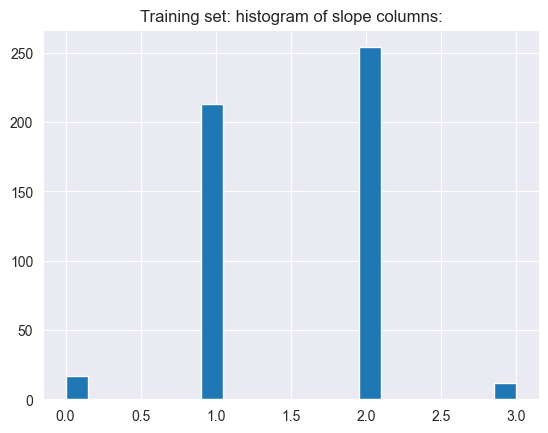

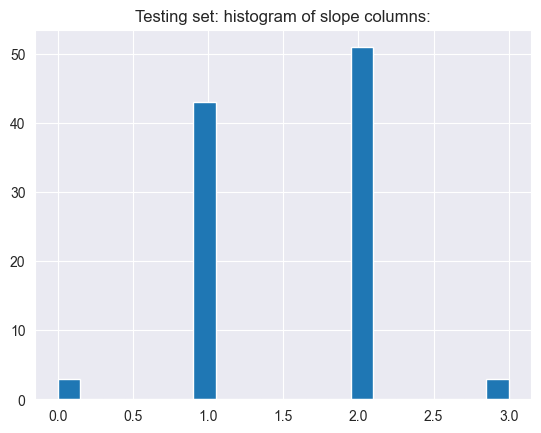

In [64]:
y_slope_train.hist(bins=20)
plt.title("Training set: histogram of slope columns:")
plt.show()

y_slope_test.hist(bins=20)
plt.title("Testing set: histogram of slope columns:")
plt.show()


In [65]:


# cross_val_score(auc_xgb_clf,
#                 X_slope_train,
#                 y_slope_train,
#                 params= {"sample_weight": np.where((y_slope_train.to_numpy() == 0) | (y_slope_train.to_numpy() == 3), 4, 1)},
#                 cv=5).mean()

In [66]:
slope_xgb_clf = XGBClassifier(learning_rate=0.01,
                              max_depth=3,
                              n_estimators=100,
                              # subsample=0.9,
                              # colsample_bytree=0.6,
                              # gamma=0,
                              # reg_alpha=0.15,
                              # reg_lambda=0.5,
                              # # early_stopping_rounds = 50,
                              # eval_metric='merror',
                              seed=42)

slope_xgb_clf.fit(X_slope_train,
                  y_slope_train,
                  sample_weight=np.where((y_slope_train.to_numpy() == 0) | (y_slope_train.to_numpy() == 3), 4, 1),
                  verbose=True)

# sample_weight=compute_sample_weight(class_weight="balanced", y=y_slope_train),
y_slope_train_pred = slope_xgb_clf.predict(X_slope_train)
y_slope_train_proba = slope_xgb_clf.predict_proba(X_slope_train)
print("Train_acc:", accuracy_score(y_slope_train, y_slope_train_pred))
print("Train_f1: ", f1_score(y_slope_train, y_slope_train_pred, average="weighted"))
print("Train_auc:", roc_auc_score(y_slope_train, y_slope_train_proba, multi_class="ovr"))

y_slope_test_pred = slope_xgb_clf.predict(X_slope_test)
y_slope_test_proba = slope_xgb_clf.predict_proba(X_slope_test)
print("Test_acc: ", accuracy_score(y_slope_test, y_slope_test_pred))
print("Test_f1:  ", f1_score(y_slope_test, y_slope_test_pred, average="weighted"))
print("Test_auc:", roc_auc_score(y_slope_test, y_slope_test_proba, multi_class="ovr"))

Train_acc: 0.75
Train_f1:  0.7512200156253958
Train_auc: 0.8943107854733994
Test_acc:  0.6
Test_f1:   0.5895909090909092
Test_auc: 0.748586414843291


In [67]:
print("Confusion matrix for test data to predict Slope values:")
print(confusion_matrix(y_slope_test, y_slope_test_pred))

Confusion matrix for test data to predict Slope values:
[[ 1  0  2  0]
 [ 2 22 18  1]
 [ 0 14 37  0]
 [ 0  1  2  0]]


In [68]:
supplement_dataset_slope_nan["slope"] = slope_xgb_clf.predict(
    supplement_dataset_slope_nan.drop(columns=["target", "slope"]))

/var/folders/44/w406vwt16zl0wwv25rzht4fc0000gn/T/ipykernel_66919/2999166162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supplement_dataset_slope_nan["slope"] = slope_xgb_clf.predict(


In [69]:
supplement_dataset = pd.concat([supplement_dataset_slope_nan, supplement_dataset_slope_non_nan], axis=0,
                               ignore_index=True)

In [70]:
for col in supplement_dataset.columns:
    if (supplement_dataset[col] % 1 == 0).all():
        supplement_dataset[col] = supplement_dataset[col].astype(int)
        supplement_dataset_test[col] = supplement_dataset_test[col].astype(int)


In [71]:
supplement_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762 entries, 0 to 761
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       762 non-null    int64  
 1   sex       762 non-null    int64  
 2   cp        762 non-null    int64  
 3   trestbps  762 non-null    int64  
 4   chol      762 non-null    int64  
 5   fbs       762 non-null    int64  
 6   restecg   762 non-null    int64  
 7   thalachh  762 non-null    float64
 8   exang     762 non-null    int64  
 9   oldpeak   762 non-null    float64
 10  slope     762 non-null    int64  
 11  target    762 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 71.6 KB


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'cp'}>],
       [<Axes: title={'center': 'trestbps'}>,
        <Axes: title={'center': 'chol'}>,
        <Axes: title={'center': 'fbs'}>],
       [<Axes: title={'center': 'restecg'}>,
        <Axes: title={'center': 'thalachh'}>,
        <Axes: title={'center': 'exang'}>],
       [<Axes: title={'center': 'oldpeak'}>,
        <Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'target'}>]], dtype=object)

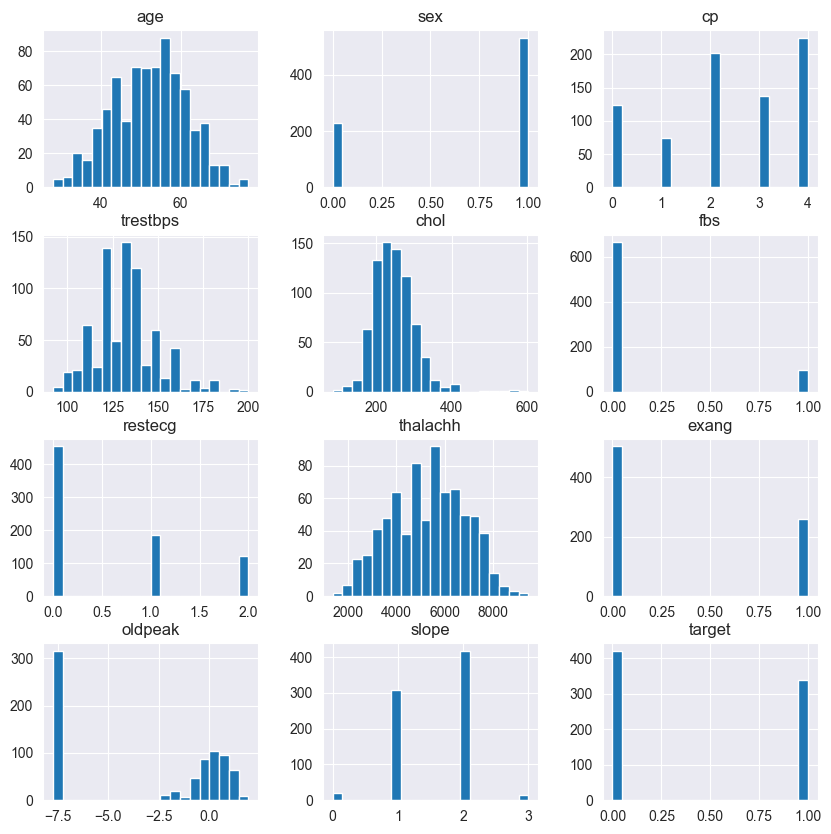

In [72]:
supplement_dataset.hist(bins=20, figsize=(10, 10))

In [73]:
supplement_dataset.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,target
age,1.000000,-0.092656,-0.087601,0.242392,0.155195,0.162923,0.144430,-0.324213,0.142772,0.330464,-0.087767,0.054819
sex,-0.092656,1.000000,0.054718,0.013447,-0.105693,0.053849,-0.031123,-0.079983,0.132141,0.049484,-0.028585,0.084106
cp,-0.087601,0.054718,1.000000,0.012215,0.060160,-0.004841,0.065981,-0.146948,0.061514,-0.013258,0.214758,0.233598
trestbps,0.242392,0.013447,0.012215,1.000000,0.130180,0.144882,0.006037,-0.102292,0.123917,0.147075,0.035233,0.040120
chol,0.155195,-0.105693,0.060160,0.130180,1.000000,0.023745,0.040190,-0.067635,0.110666,0.093400,0.015374,0.096972
fbs,0.162923,0.053849,-0.004841,0.144882,0.023745,1.000000,0.027476,0.012086,0.026271,0.061985,-0.016814,0.061141
restecg,0.144430,-0.031123,0.065981,0.006037,0.040190,0.027476,1.000000,0.024794,0.067698,0.094454,0.049318,0.123005
thalachh,-0.324213,-0.079983,-0.146948,-0.102292,-0.067635,0.012086,0.024794,1.000000,-0.381380,-0.306552,-0.083330,-0.063880
exang,0.142772,0.132141,0.061514,0.123917,0.110666,0.026271,0.067698,-0.381380,1.000000,0.378701,0.067187,0.172281
oldpeak,0.330464,0.049484,-0.013258,0.147075,0.093400,0.061985,0.094454,-0.306552,0.378701,1.000000,-0.048704,0.197083


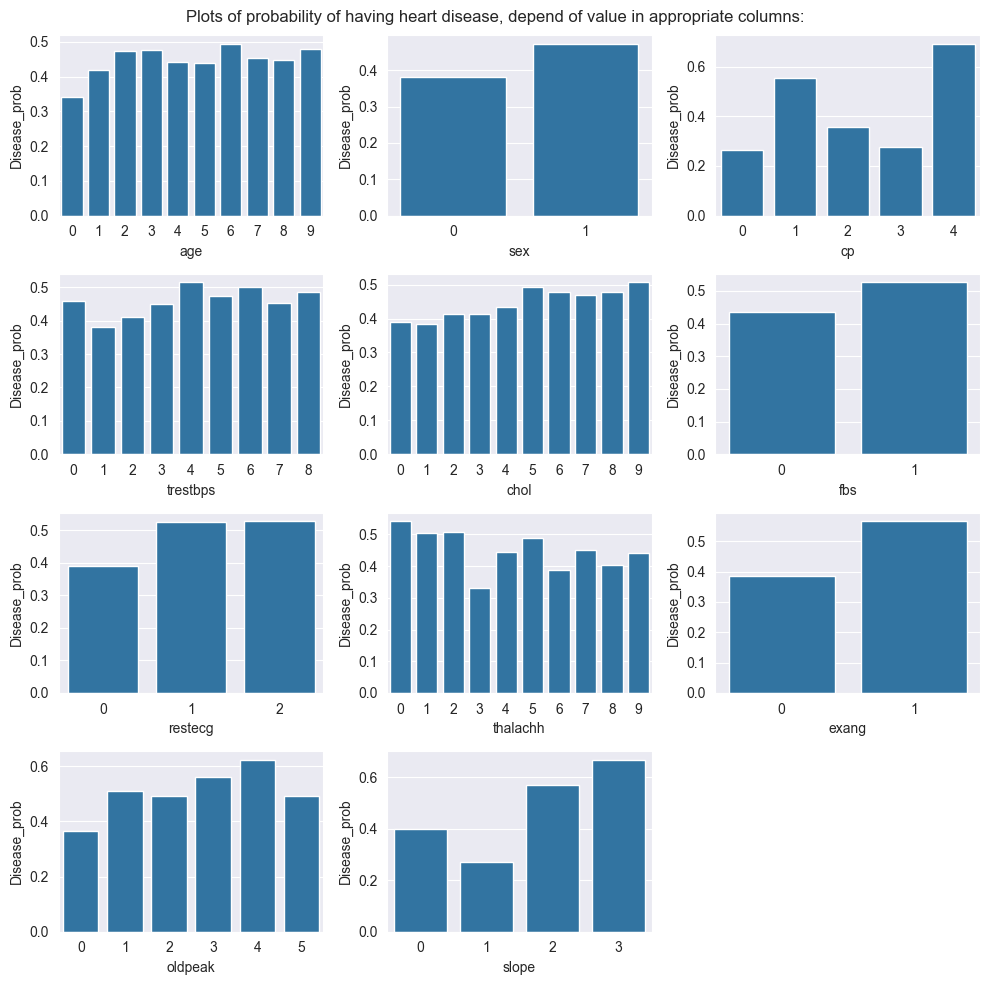

In [74]:
plot_target_probability(supplement_dataset)

### XGBoost

In [75]:
supplement_xgb_model = XGBClassifier(learning_rate=0.001,
                                     max_depth=5,
                                     n_estimators=2500,
                                     # subsample=0.9,
                                     # colsample_bytree=0.95,
                                     gamma=1.1,
                                     # reg_alpha=0.05,
                                     reg_lambda=1,
                                     # # early_stopping_rounds = 50,
                                     seed=42)

score = cross_val_score(supplement_xgb_model,
                        supplement_dataset.drop(columns=["target"]),
                        supplement_dataset["target"],
                        cv=5).mean()

print(f"XGBoost cross validation score: {round(score, 2)}")

XGBoost cross validation score: 0.67


In [76]:
supplement_xgb_model.fit(supplement_dataset.drop(columns=["target"]),
                         supplement_dataset["target"],
                         verbose=True)
print("XGBoost results: ")

y_train_pred = supplement_xgb_model.predict(supplement_dataset.drop(columns=["target"]))
print(f"Train_acc: {round(accuracy_score(supplement_dataset.target, y_train_pred), 2)}")
print(f"Train_f1:  {round(f1_score(supplement_dataset.target, y_train_pred), 2)}")

y_test_pred = supplement_xgb_model.predict(supplement_dataset_test.drop(columns=["target"]))
print(f"Test_acc:  {round(accuracy_score(supplement_dataset_test['target'], y_test_pred), 2)}")
print(f"Test_f1:   {round(f1_score(supplement_dataset_test['target'], y_test_pred), 2)}")

XGBoost results: 
Train_acc: 0.86
Train_f1:  0.83
Test_acc:  0.71
Test_f1:   0.68


In [77]:
print("Confusion Matrix for test data:")
print(confusion_matrix(supplement_dataset_test["target"], y_test_pred))

Confusion Matrix for test data:
[[40 11]
 [18 31]]


### Neural Network

In [78]:
supplement_train_dataloader, supplement_eval_dataloader = make_dataloader(supplement_dataset)

In [79]:
supplement_net_model = Net(input_size=len(supplement_dataset.columns) - 1,
                           n_neurons_per_layer=10,
                           n_layers=3,
                           ).to(device)

supplement_losses, supplement_state_dict = train(supplement_net_model,
                                                 supplement_train_dataloader,
                                                 supplement_eval_dataloader,
                                                 epochs=300, lr=0.01, scheduler_gamma=1
                                                 )

1/300 Train loss: 0.6763916936787692 | Train acc: 0.5159722222222223 Val loss:  0.6541592478752136 | Val acc: 0.6436298076923077
2/300 Train loss: 0.609112642028115 | Train acc: 0.6698232323232323 Val loss:  0.6157758235931396 | Val acc: 0.6899038461538461
3/300 Train loss: 0.5755725394595753 | Train acc: 0.704229797979798 Val loss:  0.6050464510917664 | Val acc: 0.7055288461538461
4/300 Train loss: 0.5615430989048698 | Train acc: 0.6971906565656565 Val loss:  0.5925975441932678 | Val acc: 0.7055288461538461
5/300 Train loss: 0.5437740819020704 | Train acc: 0.7129734848484849 Val loss:  0.5996361672878265 | Val acc: 0.6748798076923077
6/300 Train loss: 0.5330878902565349 | Train acc: 0.716635101010101 Val loss:  0.5763405561447144 | Val acc: 0.7590144230769231
7/300 Train loss: 0.5199319882826372 | Train acc: 0.7264204545454546 Val loss:  0.5958380997180939 | Val acc: 0.6670673076923077
8/300 Train loss: 0.5047669383612546 | Train acc: 0.751104797979798 Val loss:  0.5920926928520203 | 

In [80]:
supplement_net_model.load_state_dict(supplement_state_dict)
supplement_net_model.eval()
supplement_net_model.to("cpu")

print("Neural Network results:")

y_train_pred = supplement_net_model(torch.Tensor(supplement_dataset.drop(columns=["target"]).to_numpy())).detach() > 0.5
print(f"Train_acc: {round(accuracy_score(supplement_dataset['target'], y_train_pred), 2)}")
print(f"Train_f1:  {round(f1_score(supplement_dataset['target'], y_train_pred), 2)}")

y_test_pred = supplement_net_model(
    torch.Tensor(supplement_dataset_test.drop(columns=["target"]).to_numpy())).detach() > 0.5
print(f"Test_acc:  {round(accuracy_score(supplement_dataset_test['target'], y_test_pred), 2)}")
print(f"Test_f1:   {round(f1_score(supplement_dataset_test['target'], y_test_pred), 2)}")

Neural Network results:
Train_acc: 0.75
Train_f1:  0.73
Test_acc:  0.7
Test_f1:   0.7


In [81]:
print("Confusion matrix for test data:")
print(confusion_matrix(supplement_dataset_test["target"], y_test_pred))

Confusion matrix for test data:
[[35 16]
 [14 35]]


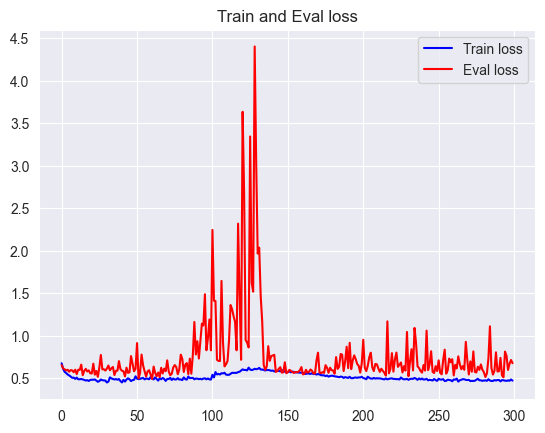

In [82]:
plt.plot(supplement_losses[0], "b", label="Train loss")
plt.plot(supplement_losses[2], "r", label="Eval loss")
plt.legend()
plt.title("Train and Eval loss")
plt.show()

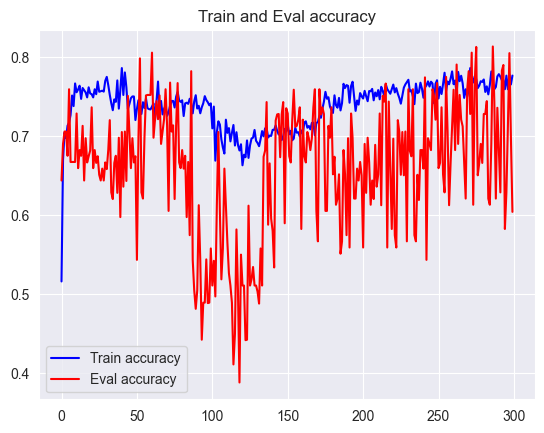

In [83]:
plt.plot(supplement_losses[1], "b", label="Train accuracy")
plt.plot(supplement_losses[3], "r", label="Eval accuracy")
plt.legend()
plt.title("Train and Eval accuracy")
plt.show()

# Conclusions:
For this dataset, the best way to deal with missing values is filling using median.